Running a scalability test with a random SNN with SuperNeuroMAT.

In [1]:
import time
import random
import numpy as np
from superneuromat.neuromorphicmodel import NeuromorphicModel

In [2]:
def execute_run(graph, snn_config, n_inputs, spike_times, sim_time):

    t_init_start = time.time()
    model = NeuromorphicModel()
    t_init_end = time.time()
    t_init = t_init_end - t_init_start

    t_create_start = time.time()

    for _ in graph.nodes:
        _ = model.create_neuron(
            threshold=snn_config["threshold"],
            leak = snn_config["leak"],
            reset_state=snn_config["reset_val"],
        )
        
    for edge in graph.edges:
        pre_neuron = edge[0]
        post_neuron = edge[1]
        model.create_synapse(
            pre_neuron,
            post_neuron,
            weight=snn_config["syn_wt"],
            delay=snn_config["syn_delay"],
        )

    # set the input neurons receiving external stimulus:
    spiking_neurons = random.choices(range(len(graph.nodes)), k=n_inputs)

    for n in spiking_neurons:
        for t in spike_times:
            model.add_spike(int(t),int(n), 1)

    model.setup()

    t_create_end = time.time()
    t_create = t_create_end - t_create_start
    

    t_sim_start = time.time()
    # Simulate for sim_time steps:
    model.simulate(time_steps=sim_time)
    t_sim_end = time.time()
    t_sim = t_sim_end - t_sim_start
    
    t_mon_start = time.time()
    # Get spike times
    net_spikes = model.spike_train

    t_mon_end = time.time()
    t_mon = t_mon_end - t_mon_start
    
    return t_init, t_create, t_sim, t_mon

In [3]:
# Loads the network onto the requested simulator and runs for the specified timesteps
# Simulation is run for 1000ms (1000 timesteps)

import numpy as np
import networkx as nx

# Define the simulation parameters:
connection_probability = 0.5
seed = 42
syn_delay = 1
syn_wt = 1.0
threshold = 1.0
refractory_period = 0
reset_val = 0
leak = 0.0
sim_time = 10000
spike_time_intervals = 10
spike_times = np.arange(1.0, sim_time, spike_time_intervals)
use_gpu = False

n_neurons = 100
n_inputs = int(0.3  * n_neurons)

# Create the networkx random graph with given connection probability:
np.random.seed(seed)
graph = nx.binomial_graph(n_neurons, connection_probability)

snn_config = {}
snn_config["threshold"] = threshold
snn_config["syn_wt"] = syn_wt
snn_config["syn_delay"] = syn_delay
snn_config["refractory_period"] = refractory_period
snn_config["reset_val"] = reset_val
snn_config["leak"] = leak
snn_config["n_neurons"] = n_neurons

# Run a sample simulation:
execute_run(
    graph, snn_config, n_inputs, spike_times, sim_time
)

(7.867813110351562e-06, 0.02986907958984375, 0.456406831741333, 0.0)

In [4]:
import numpy as np
import pandas as pd

# Compare the scalability performance:
neurons = [100, 1000, 10000]
density = [0.25, 0.5, 0.75, 1.0]

tests = 3
seeds = [np.random.randint(0, 100000000) for i in range(tests)]

df = pd.DataFrame(columns = ['n_neurons', 'density', 'init_time', 'create_time', 'sim_time', 'mon_time', 'total_time'],
        index = [i for i in range(tests*len(neurons)*len(density))])

i=0
for t in range(tests):
    for n in neurons:
        for d in density:
            n_inputs = int(0.3*n)
            graph = nx.binomial_graph(n, d)
            t_init, t_create, t_sim, t_mon = execute_run(
                                                graph, snn_config, n_inputs, spike_times, sim_time
                                                )
            
            print(n, d, t_init, t_create, t_sim, t_mon)
            df.loc[i,'n_neurons'] = n
            df.loc[i,'density'] = d
            df.loc[i,'init_time'] = t_init
            df.loc[i,'create_time'] = t_create
            df.loc[i,'sim_time'] = t_sim
            df.loc[i,'mon_time'] = t_mon
            df.loc[i,'total_time'] = t_init + t_create + t_sim + t_mon
            i+=1
           

100 0.25 9.5367431640625e-06 0.06061387062072754 0.4908266067504883 2.384185791015625e-07
100 0.5 1.5974044799804688e-05 0.025131702423095703 0.44381237030029297 2.384185791015625e-07
100 0.75 2.86102294921875e-06 0.02652597427368164 0.43294763565063477 4.76837158203125e-07
100 1.0 2.86102294921875e-06 0.027328014373779297 0.43962550163269043 2.384185791015625e-07
1000 0.25 7.152557373046875e-06 0.34630680084228516 2.8090274333953857 2.384185791015625e-07
1000 0.5 1.0013580322265625e-05 0.48572802543640137 2.4776480197906494 7.152557373046875e-07
1000 0.75 5.14984130859375e-05 0.6247718334197998 2.344886302947998 9.5367431640625e-07
1000 1.0 1.0728836059570312e-05 0.7712883949279785 2.425121545791626 4.76837158203125e-07
10000 0.25 4.649162292480469e-05 16.345247507095337 87.05152940750122 1.430511474609375e-06
10000 0.5 3.075599670410156e-05 29.41041135787964 128.76863956451416 7.152557373046875e-07
10000 0.75 3.719329833984375e-05 43.72053623199463 88.02747082710266 7.152557373046875

In [5]:
display(df)

,n_neurons,density,init_time,create_time,sim_time,mon_time,total_time
0,100,0.25,0.00001,0.060614,0.490827,0.0,0.55145
1,100,0.5,0.000016,0.025132,0.443812,0.0,0.46896
2,100,0.75,0.000003,0.026526,0.432948,0.0,0.459477
3,100,1.0,0.000003,0.027328,0.439626,0.0,0.466957
4,1000,0.25,0.000007,0.346307,2.809027,0.0,3.155342
5,1000,0.5,0.00001,0.485728,2.477648,0.000001,2.963387
6,1000,0.75,0.000051,0.624772,2.344886,0.000001,2.969711
7,1000,1.0,0.000011,0.771288,2.425122,0.0,3.196421
8,10000,0.25,0.000046,16.345248,87.051529,0.000001,103.396825
9,10000,0.5,0.000031,29.410411,128.76864,0.000001,158.179082


ValueError: x and y must have same first dimension, but have shapes (1,) and (3,)

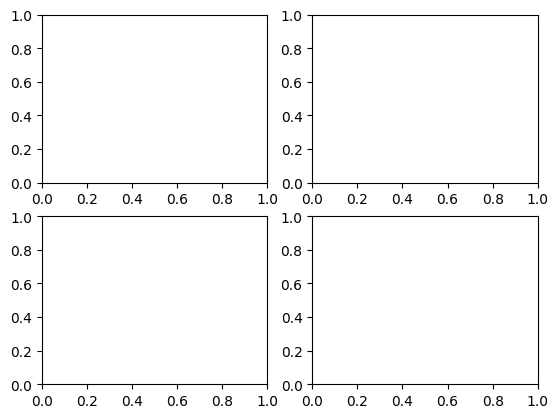

In [6]:
# Plots:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2,2)

symbols = ["s", "o", "P", "^", "v"]

for i in range(len(density)):
    s = density[i]
    r = int(i/2)
    c = int(i%2)
    means = []
    stddevs = []
    for n in neurons:
        x = np.array(df[df["n_neurons"] == n]["total_time"])
        x = np.where(x == -1, 900, x)
        mu = np.mean(x)
        sigma = np.std(x)
        if (mu == -1):
            mu = 900
            sigma = 0
        means.append(mu)
        stddevs.append(sigma)
    axes[r,c].plot(n_neurons, means, label=s, marker=symbols[i])
    axes[r,c].fill_between(n_neurons, np.subtract(means, stddevs), np.add(means, stddevs), alpha=0.3)
    axes[r,c].set_title("Synaptic Density = " + str(s))
    axes[r,c].plot(range(0,1000), [900]*1000, '--k')
    axes[r,c].set_ylabel("Time (in seconds)")
if (r == 1):
    axes[r,c].set_xlabel("Number of Neurons")
else:
    axes[r,c].set_xticklabels([])
                
axes[0,1].legend()
plt.show()
